In [129]:
import random as rand
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#Fix the randomness
seed = 1234
rand.seed(seed)

import pandas as pd
import random

def load_data(input_file):
    data = pd.read_csv(input_file)
    return data

def split_data(input_file, output_file_1, output_file_2, ratio_split=0.2):
    df = pd.read_csv(input_file)

    # Remove columns: date, country, street (Since every data is collected inside USA)
    df = df.drop(columns=["date", "country", "street"])

    # 1. Filter noisy data (house with prices == 0.0)
    df = df[df["price"] > 100]

    # 2. Remove the records belong to the cities that has less than 5 instances
    city_counts = df['city'].value_counts()
    
    cities_to_keep = city_counts[city_counts >= 5].index
    df = df[df['city'].isin(cities_to_keep)]

    ## Normalize the data:
    #1. year_built = subtract the minimum year_built from all the year_built
    #2. year_renovated = make 3 classes, 0 is never renovated, 1 is renovated before 2000, 2 is renovated after 2000 
    #3. sqft_living = normalize
    #4. sqft_lot = normalize
    #5. sqft_above = normalize
    #6. sqft_basement = normalize

    # 1. Normalize the yr_built
    print(f"Minimum yr_built: {df['yr_built'].min()}")
    df['yr_built'] = df['yr_built'] - df['yr_built'].min()
    
    # 2. Normalize the year_renovated
            # 0: Not innovated
            # 1: From 1900 to 1920
            # 2: From 1920 to 1940
            # 3: From 1940 to 1960
            # 4: From 1960 to 1980
            # 5: From 1980 to 2000
            # 6: From 2000 to now
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    df['yr_renovated'].hist(bins=32, edgecolor='black', ax=axes[0])
    axes[0].set_xlabel('Values in yr_renovated')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Histogram of Values in yr_renovated')

    df[df['yr_renovated'] != 0]['yr_renovated'].hist(bins=32, edgecolor='black', ax=axes[1])
    axes[1].set_xlabel('Values in yr_renovated')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Histogram of Non-Zero Values in yr_renovated')
    plt.tight_layout()
    plt.show()

    bins = [-1, 1899, 1920, 1940, 1960, 1980, 2000, pd.to_datetime('now').year]
    labels = [0, 1, 2, 3, 4, 5, 6]
    df['yr_renovated'] = pd.cut(df['yr_renovated'], bins=bins, labels=labels, right=False)

    # 3. Normalize all the square feet

    columns_to_normalize = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
    scaler = MinMaxScaler()
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])




    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    total_rows = len(df)
    split_index = int(total_rows * (1 - ratio_split))

    set_1 = df.iloc[:split_index, :]
    set_2 = df.iloc[split_index:, :]

    set_1.to_csv(output_file_1, index=False, header = True)
    set_2.to_csv(output_file_2, index=False, header = True)
    return None

## 1. Create the database.txt file and evalutation.txt

Minimum yr_built: 1900


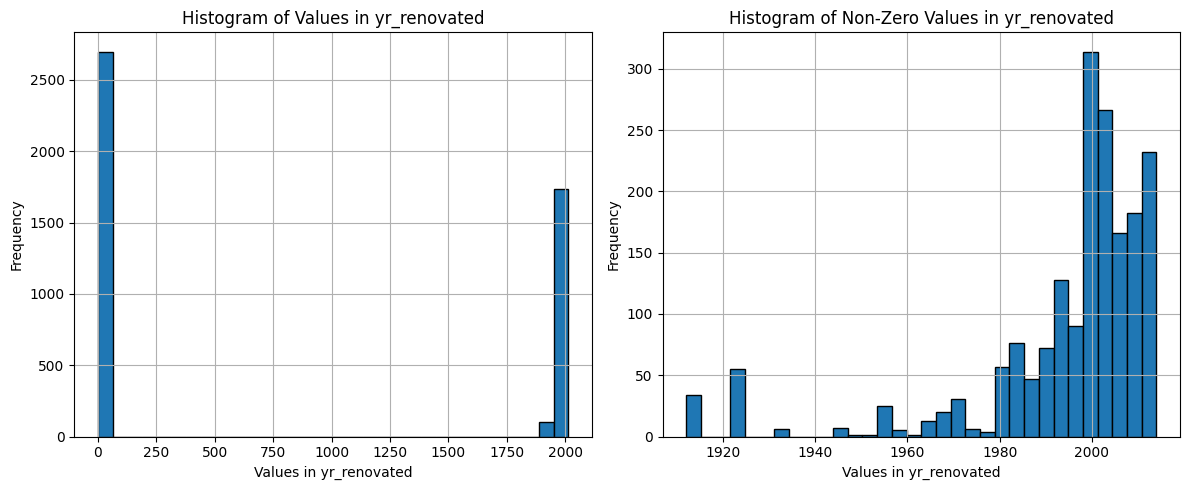

In [130]:
input_file_path = 'data.csv'
output_file_1_path = 'database.csv'
output_file_2_path = 'evaluation.csv'
split_ratio = 0.2

split_data(input_file_path, output_file_1_path, output_file_2_path, split_ratio)

## 2. Load the dataset 

In [131]:
database = load_data('database.csv')
# #Normalize the data:
# database=(database-database.min())/(database.max()-database.min())

evaluation = load_data('evaluation.csv')

#Create a dictionary for weights:
weight_dist = {}
weight_dist['sqft_living'] = 1.0
weight_dist['sqft_lot'] = 0.1
weight_dist['sqft_above'] = 0.1
weight_dist['sqft_basement'] = 0.25


#Pick a random sample from database
sample = database.iloc[2828]

In [132]:
print(database.head(4))
print("---------------------------------")
print(f"A sample : {sample}")
print("---------------------------------")
print(f"The weight dictionary : {weight_dist}")

       price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0   479900.0       3.0        2.0     0.122248  0.010723     1.0           0   
1  1120000.0       5.0        1.5     0.164768  0.005609     2.0           0   
2   625000.0       4.0        1.0     0.093394  0.004529     1.5           0   
3   400000.0       2.0        1.0     0.035687  0.004538     1.0           0   

   view  condition  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3    0.178097       0.000000        94             0   
1     3          4    0.217920       0.041494        54             4   
2     0          4    0.136062       0.000000        46             5   
3     0          3    0.051991       0.000000        55             6   

      city  statezip  
0     Kent  WA 98042  
1  Seattle  WA 98136  
2  Seattle  WA 98117  
3  Seattle  WA 98136  
---------------------------------
A sample : price            477000.0
bedrooms              3.0
bathrooms            

In [133]:
communities = database.groupby(['city', 'statezip']).size().reset_index(name='numberOfInstances')
print(communities) #102 communities

           city  statezip  numberOfInstances
0        Algona  WA 98001                  5
1        Auburn  WA 98001                 41
2        Auburn  WA 98002                 31
3        Auburn  WA 98092                 68
4      Bellevue  WA 98004                 42
..          ...       ...                ...
91      Tukwila  WA 98178                  3
92      Tukwila  WA 98188                  5
93       Vashon  WA 98070                 23
94  Woodinville  WA 98072                 46
95  Woodinville  WA 98077                 45

[96 rows x 3 columns]


In [134]:
communities_dict = {}
for city, city_group in database.groupby('city'):
    city_dict = {}
    for (zipcode, zip_group) in city_group.groupby('statezip'):
        city_dict[zipcode] = zip_group.drop(columns=['city', 'statezip'])
    communities_dict[city] = city_dict

# Testing
print(communities_dict["Algona"]["WA 98001"])

         price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
252   196440.0       3.0        2.0     0.090357  0.006254     1.0   
468   100000.0       2.0        1.0     0.041002  0.019898     1.0   
1051  262000.0       4.0        2.5     0.125285  0.005214     2.0   
2242  230000.0       3.0        1.0     0.077449  0.014309     1.0   
2356  248000.0       4.0        3.0     0.136143  0.004886     2.0   

      waterfront  view  condition  sqft_above  sqft_basement  yr_built  \
252            0     0          3    0.131637            0.0        92   
468            0     0          3    0.059735            0.0        56   
1051           0     0          3    0.182522            0.0       102   
2242           0     0          4    0.112832            0.0        60   
2356           0     0          3    0.198341            0.0       106   

      yr_renovated  
252              0  
468              6  
1051             0  
2242             6  
2356             0  


In [135]:
def find_community(sample, communities_dict, neighborhood_mini=5):
    #Return a dataframe
    sample_zipcode = sample['statezip']
    sample_city = sample['city']
    closest_zone_samples = communities_dict[sample_city][sample_zipcode]
    if(len(closest_zone_samples) > neighborhood_mini):
        return closest_zone_samples
    else:
        closest_zone_samples = pd.DataFrame()
        for statezip in communities_dict[sample_city]:
            closest_zone_samples = pd.concat([closest_zone_samples, communities_dict[sample_city][statezip]])
        return closest_zone_samples

def find_k_neighbors(sample, database, k=5):
    closest_zone_samples = find_community(sample, database)
    samples_distance = []
    for neighbor in closest_zone_samples:
        samples_distance.append(cal_distance(sample, neighbor))
    samples_distance.sort()
    return samples_distance[:k]

def cal_distance(sample, another_sample, weight_dist = weight_dist):
    difference = 0.0
    for k,v in weight_dist.items():
        difference += v * (sample[k] - another_sample[k])
    return difference

def adapt_price_from_dissimilarities(sample, neighbor, weight_dict):
    init_price = neighbor['price']
    square_meter_price = init_price / neighbor['sqft_living']
    for key in weight_dict:
        if key == 'price':
            init_price += square_meter_price * (sample['sqft_living'] - neighbor['sqft_living'])
    return init_price

In [136]:
find_community(sample, communities_dict, neighborhood_mini=3)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
316,425000.0,3.0,2.50,0.113895,0.004481,2.0,0,0,3,0.165929,0.000000,103,0
346,400000.0,4.0,2.50,0.164009,0.006450,1.0,0,0,3,0.118363,0.226141,78,0
515,443000.0,3.0,2.25,0.117692,0.007065,2.0,0,0,4,0.171460,0.000000,89,0
765,571000.0,3.0,2.50,0.169324,0.006359,2.0,0,0,3,0.246681,0.000000,88,6
1101,458000.0,5.0,2.50,0.206530,0.021076,1.0,0,0,3,0.289823,0.020747,57,6
1153,540000.0,5.0,3.00,0.189825,0.003475,2.0,0,0,3,0.190265,0.161826,107,0
1166,531000.0,3.0,2.50,0.132878,0.008474,2.0,0,0,3,0.193584,0.000000,88,6
1311,435000.0,4.0,2.75,0.132118,0.007557,1.0,0,0,3,0.126106,0.124481,62,6
1402,425000.0,3.0,2.25,0.113895,0.007789,1.0,0,0,3,0.118363,0.089212,78,0
1481,420000.0,3.0,1.75,0.097950,0.008348,1.0,0,0,3,0.111726,0.058091,81,6


## 2. Loop to find the optimal weights for adaptation